# 개와 고양이 Image classification

이 예제에서는 개와 고양이 사진을 분류하는 이미지 분류기를 생성할 것이다. 모델 생성은 `tf.keras.Sequential` 을 이용하고, 이미지를 전처리하기 위해서는 `tf.keras.preprocessing.image.ImageDataGenerator`를 사용한다.

분류기의 성능을 향상시키고 overfitting을 해결하기 위해서 **이미지 augmentation과 dropout을 사용**한다.

기본적인 workflow:

1. data를 읽어 들인다.
2. input pipeline을 생성한다.
3. model을 생성한다.
4. model을 훈련한다.
5. model을 테스트한다.
6. 성능을 향상 시킬 방법을 적용하여 본다.

## Import packages

`os` package는 directory에서 데이터 파일을 읽어 들이기 위해 사용한다. 

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

데이터 셋은 다음과 같은 디렉토리 구조를 가지고 있다.:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

읽어들인 훈련데이터와 validation 데이터를 확인한다.

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


데이터를 전처리하고 훈련하는데 필요한 상수를 정의한다.

In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

데이터 전처리를 다음과 같이 수행한다.

1. 디스크에 있는 이미지 파일을 읽는다.
2. tensors의 값이 0 과 255인 것을 0 과 1 사이의 값으로 rescale한다.,

`tf.keras`의 `ImageDataGenerator`를 사용하면 파일을 적절하게 전처리 하여 텐서로 읽어 들인다. 

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

훈련데이터, validation 데이터 generators 를 생성하고 , `flow_from_directory` method를 사용하여 이미지를 로드한다. 로드 할 때 rescaling과 resizes가 수행된다.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualize training images

 `matplotlib`를 사용하여 읽어 들인 이미지를 출력해 본다..

In [11]:
sample_training_images, _ = next(train_data_gen)

`next` function 는 데이터셋에서 데이터를 읽어 들인다. `next` function의 리턴 값은 `(x_train, y_train)` 형태이다.

In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

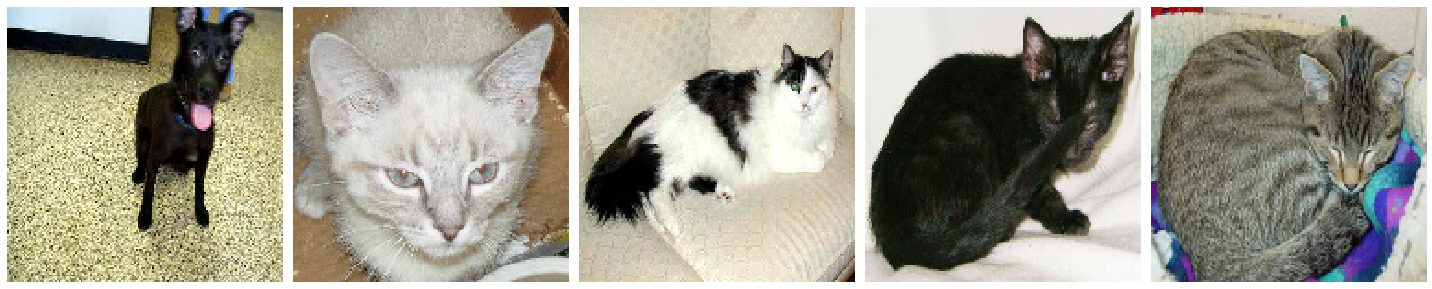

In [13]:
plotImages(sample_training_images[:5])

## Create the model

3개의 convolution blocks이 각각 max pool layer를 포함한다. 마지막 fully connected layer 는 512 units 이다. `relu` activation function를 사용한다. model의 최종 출력은 `sigmoid` activation function으로 계산된 클래스 확률값이다.

In [14]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compile the model

*ADAM* optimizer와 *binary cross entropy* loss function을 사용한다.`metrics` argument를 써서 정확도를 체크한다.

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model summary

`summary` method:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

`ImageDataGenerator` class 의 `fit` method를 사용하여 모형을 훈련한다.

In [17]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 35s 2s/step - loss: 1.3336 - accuracy: 0.4904 - val_loss: 0.6915 - val_accuracy: 0.5592
Epoch 2/15
15/15 [==============================] - 22s 1s/step - loss: 0.6863 - accuracy: 0.5529 - val_loss: 0.6895 - val_accuracy: 0.5078
Epoch 3/15
15/15 [==============================] - 22s 1s/step - loss: 0.6530 - accuracy: 0.5903 - val_loss: 0.6204 - val_accuracy: 0.6931
Epoch 4/15
15/15 [==============================] - 23s 2s/step - loss: 0.5829 - accuracy: 0.6944 - val_loss: 0.6069 - val_accuracy: 0.6886
Epoch 5/15
15/15 [==============================] - 22s 1s/step - loss: 0.5387 - accuracy: 0.7420 - val_loss: 0.5716 - val_accuracy: 0.7176
Epoch 6/15
15/15 [==============================] - 22s 1s/step - loss: 0.4752 - accuracy: 0.7879 - val_loss: 0.5522 - val_accuracy: 0.7310
Epoch 7/15
15/15 [==============================] - 22s 1s/step - loss: 0.4380 - accuracy: 0.7969 - val_loss: 0.5644 - val_accuracy: 0.7232
Epoch 8/15
15/15 [==

### Visualize training results

훈련 결과를 시각화 한다.

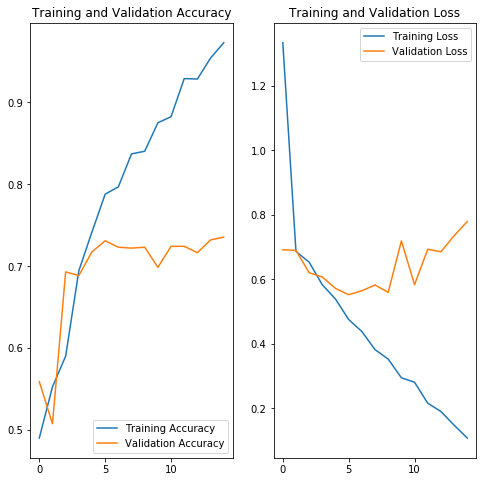

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

위 훈련 과정에서 보면 훈련이 진행됨에 따라 validataion loss가 증가하면서 오버피팅 현상을 보이고 있다.

*data augmentation* 과  *dropout* 을 추가하여 오버피팅 문제를 해결해 보자.

## Data augmentation

오버피팅 문제를 해결하는 하나의 방법이다. 입력 이미지에 여러 가지 변환을 수행한다.

**tf.keras** 의 **ImageDataGenerator**를 사용한다.

### Apply horizontal flip

좌우 반전을 수행한다.

In [19]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [20]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

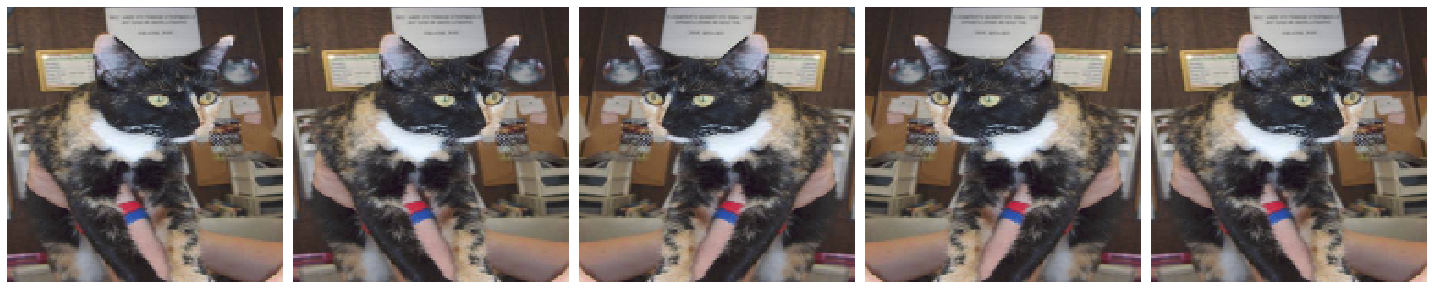

In [22]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

45도 각도로 이미지를 랜덤 회전한다.

In [23]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [24]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


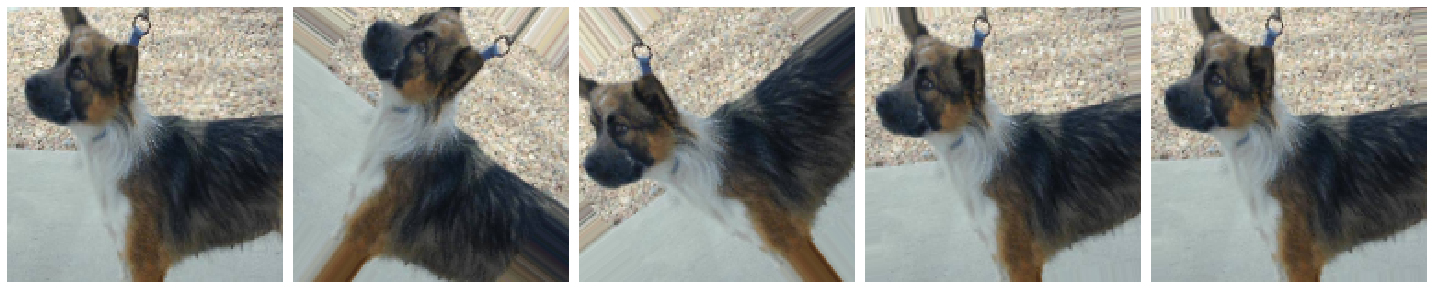

In [25]:
plotImages(augmented_images)

### Apply zoom augmentation

50%까지 random하게 zoom한다.

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


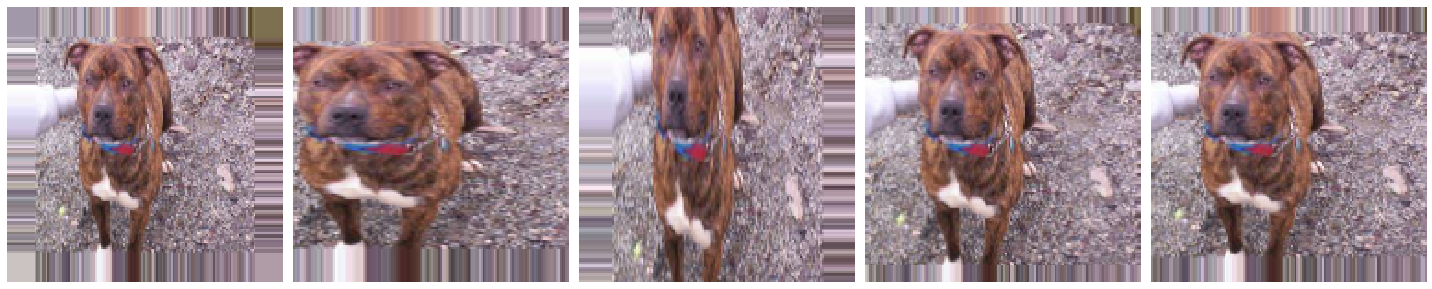

In [28]:
plotImages(augmented_images)

### Put it all together

여러가지 augmentation 기법을 합쳐서 적용한다.

In [29]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [30]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


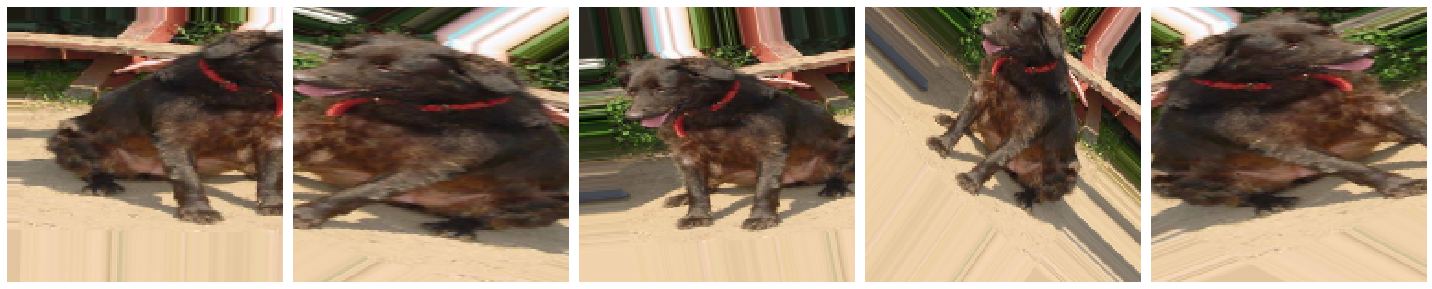

In [31]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

디렉토리의 이미지를 validation dataset으로 생성한다.

In [32]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [33]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout

오버피팅을 해결하기 위한 하나의 방법이다. 특정 비율로 모형의 unit(뉴런)를 제거한다. 


## Creating a new network with Dropouts

각 training epoch에서 50%의 뉴런을 랜덤하게 제거하여 모형의 훈련을 진행한다. overfitting문제를 어느 정도 해결할 수 있다.

In [34]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compile the model

In [35]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### Train the model

 data augmentations을 수행한 데이터셋을 사용하고 dropouts을 적용한 모형으로 훈련을 진행한다.:

In [36]:
epochs = 20

history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
15/15 [==============================] - 28s 2s/step - loss: 1.4117 - accuracy: 0.5027 - val_loss: 0.6930 - val_accuracy: 0.4989
Epoch 2/20
15/15 [==============================] - 28s 2s/step - loss: 0.6928 - accuracy: 0.4990 - val_loss: 0.6929 - val_accuracy: 0.4989
Epoch 3/20
15/15 [==============================] - 28s 2s/step - loss: 0.6929 - accuracy: 0.5021 - val_loss: 0.6926 - val_accuracy: 0.4967
Epoch 4/20
15/15 [==============================] - 27s 2s/step - loss: 0.6925 - accuracy: 0.4989 - val_loss: 0.6925 - val_accuracy: 0.5123
Epoch 5/20
15/15 [==============================] - 27s 2s/step - loss: 0.6918 - accuracy: 0.5166 - val_loss: 0.6920 - val_accuracy: 0.6049
Epoch 6/20
15/15 [==============================] - 28s 2s/step - loss: 0.6889 - accuracy: 0.5433 - val_loss: 0.6878 - val_accuracy: 0.5792
Epoch 7/20
15/15 [==============================] - 28s 2s/step - loss: 0.6888 - accuracy: 0.5331 - val_loss: 0.6906 - val_accuracy: 0.5234
Epoch 8/20
15/15 [==

### Visualize the model

모형의 수행 결과를 확인한다.

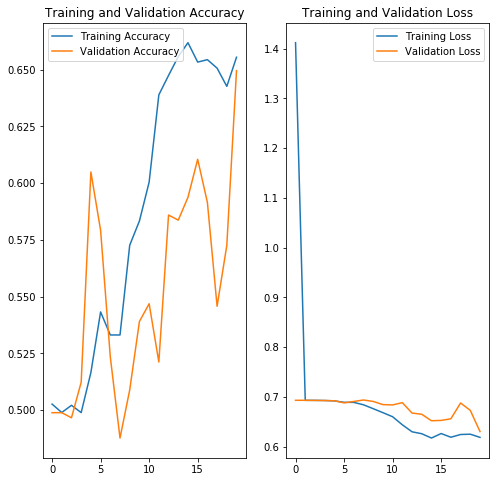

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 훈련된 모형으로 예측하기

In [38]:
probabilities = model.predict(val_data_gen,1)

print(val_data_gen.class_indices)
print(probabilities[:5])

{'cats': 0, 'dogs': 1}
[[0.58618355]
 [1.        ]
 [0.25968355]
 [0.82135445]
 [0.02141204]]


In [40]:
imgs, labels = val_data_gen.next()

preds = (model.predict(imgs) > 0.5).astype("int32") 

In [41]:
classes = ['cat','dog']

labels

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)

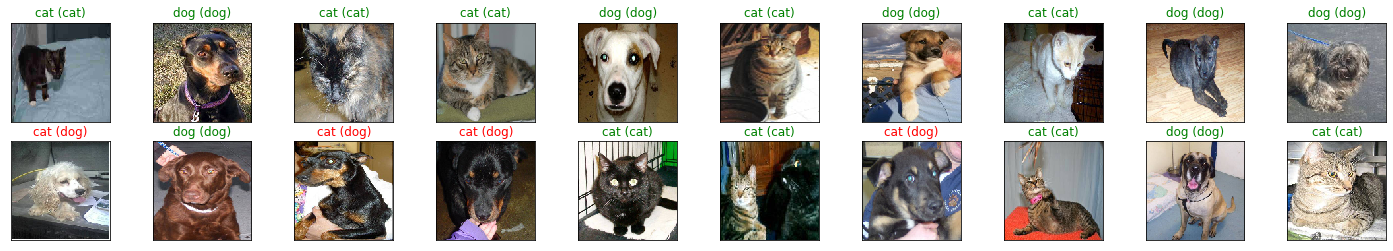

In [42]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(imgs[idx])
    ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[int(labels[idx])]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# 실습

* 개와 고양이 image classification 모형의 hyper parameter을 적절히 튜닝하여 성능을 더 향상 할 수 있도록 하시오.
* optimizer 설정, learning rate, mini batch size, drop out 등
* 모형의 구조를 변경하여 모형의 분류 성능을 향상할 수 있는 방법을 실습해 보시오.